In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

ilin = pd.read_csv("../FluViewPhase2Data/ILINet.csv", skiprows=1)

ilin.columns = ilin.columns.str.strip()

ilin["YEAR"] = pd.to_numeric(ilin["YEAR"], errors="coerce")
ilin["WEEK"] = pd.to_numeric(ilin["WEEK"], errors="coerce")
ilin["ILITOTAL"] = pd.to_numeric(ilin["ILITOTAL"], errors="coerce")
ilin["TOTAL PATIENTS"] = pd.to_numeric(ilin["TOTAL PATIENTS"], errors="coerce")

md = ilin[(ilin["REGION TYPE"] == "States") & (ilin["REGION"] == "Maryland")].copy()

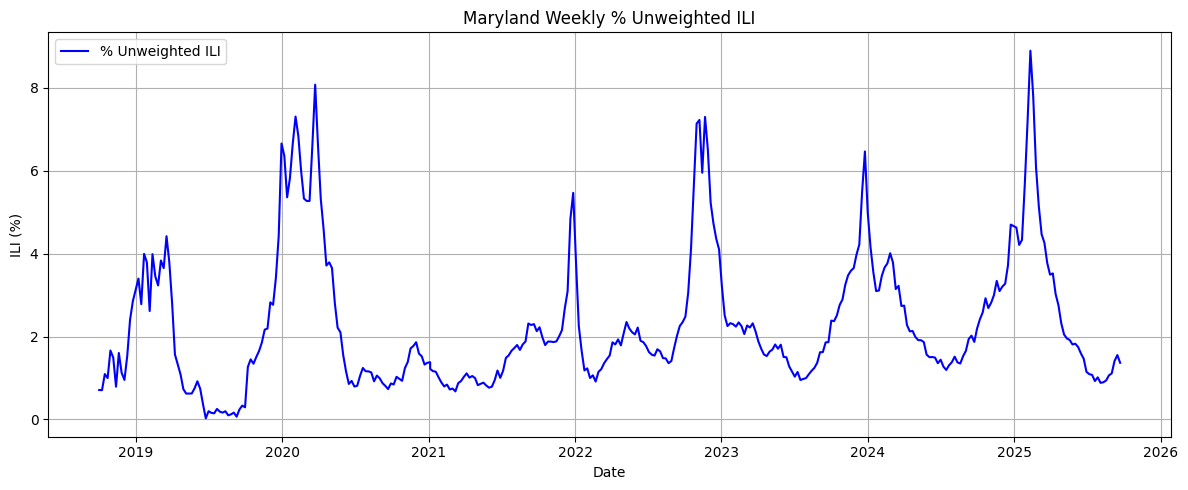

In [5]:
# Transform WEEK and YEAR to a proper DATE
md["YEAR"] = pd.to_numeric(md["YEAR"], errors="coerce")
md["WEEK"] = pd.to_numeric(md["WEEK"], errors="coerce")
md["DATE"] = pd.to_datetime(md["YEAR"].astype(int).astype(str) + md["WEEK"].astype(int).astype(str).str.zfill(2) + '1', format="%Y%W%w")

# Convert to numeric
md["%UNWEIGHTED ILI"] = pd.to_numeric(md["%UNWEIGHTED ILI"], errors="coerce")

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(md["DATE"], md["%UNWEIGHTED ILI"], label="% Unweighted ILI", color="blue")
plt.title("Maryland Weekly % Unweighted ILI")
plt.xlabel("Date")
plt.ylabel("ILI (%)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

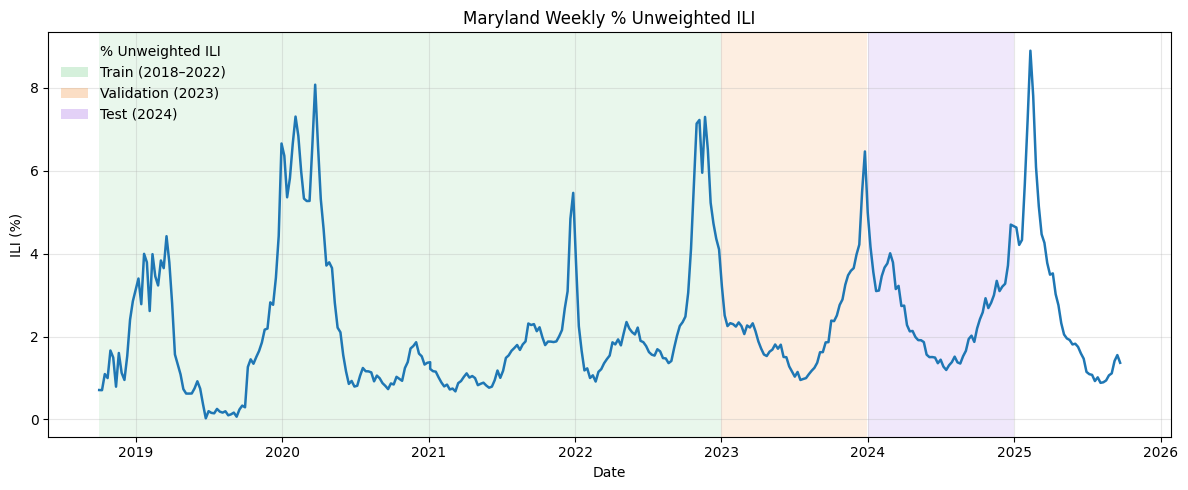

In [ ]:
# Visualization (with shaded train/val/test bands)
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 5))

# First, sort by date
md_sorted = md.sort_values("DATE")

ax.plot(md_sorted["DATE"], md_sorted["%UNWEIGHTED ILI"],
        label="% Unweighted ILI", linewidth=1.8)

ax.set_title("Maryland Weekly % Unweighted ILI")
ax.set_xlabel("Date")
ax.set_ylabel("ILI (%)")
ax.grid(True, alpha=0.3)

# === Shaded regions (by year) ===
train_start = pd.Timestamp("2018-01-01")
train_end   = pd.Timestamp("2022-12-31")
val_start   = pd.Timestamp("2023-01-01")
val_end     = pd.Timestamp("2023-12-31")
test_start  = pd.Timestamp("2024-01-01")
test_end    = pd.Timestamp("2024-12-31")

# Only shade within the data coverage range to avoid out-of-bounds
x_min, x_max = md_sorted["DATE"].min(), md_sorted["DATE"].max()

def span(ax, start, end, **kw):
    s = max(start, x_min)
    e = min(end,   x_max)
    if s < e:
        ax.axvspan(s, e, **kw)

span(ax, train_start, train_end, facecolor="#88d498", alpha=0.18)
span(ax, val_start,   val_end,   facecolor="#f4a259", alpha=0.18)
span(ax, test_start,  test_end,  facecolor="#9b5de5", alpha=0.14)

line_ili = mpatches.Patch(color="none", label="% Unweighted ILI")
train_patch = mpatches.Patch(facecolor="#88d498", alpha=0.35, label="Train (2018–2022)")
val_patch   = mpatches.Patch(facecolor="#f4a259", alpha=0.35, label="Validation (2023)")
test_patch  = mpatches.Patch(facecolor="#9b5de5", alpha=0.28, label="Test (2024)")

ax.legend(handles=[line_ili, train_patch, val_patch, test_patch], loc="upper left", frameon=False)

fig.tight_layout()
# plt.savefig("fig1_md_ili_shaded.png", dpi=300, bbox_inches="tight")
plt.show()


In [8]:
# Split the data into training, validation, and test sets
train_df = md[md["YEAR"].between(2018, 2022)]
val_df   = md[md["YEAR"] == 2023]
test_df  = md[md["YEAR"] == 2024]
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 222, Validation size: 52, Test size: 52


# M0: Classical SEIRS Baseline

In [10]:
# Define SEIRS model
def seirs(y, t, beta, sigma, gamma):
    S, E, I, R = y
    dSdt = -beta * S * I
    dEdt = beta * S * I - sigma * E
    dIdt = sigma * E - gamma * I
    dRdt = gamma * I
    return [dSdt, dEdt, dIdt, dRdt]

In [ ]:
# Construct MSE loss function
from scipy.integrate import odeint
from scipy.optimize import minimize
import numpy as np

def loss(params, t, I_observed, y0):
    beta, sigma, gamma = params
    sol = odeint(seirs, y0, t, args=(beta, sigma, gamma))
    I_pred = sol[:, 2]  # I(t)
    return np.mean((I_pred - I_observed)**2)


In [ ]:
# Normalize observed ILI to [0,1]
I_obs = train_df["%UNWEIGHTED ILI"].values / 100
t_train = np.arange(len(I_obs))

# Initialize [S0, E0, I0, R0]
I0 = I_obs[0]
S0 = 1 - I0
E0 = 0.0
R0 = 0.0
y0 = [S0, E0, I0, R0]


In [ ]:
# Fit parameters
# Initial guess
initial_params = [0.5, 0.5, 0.1]  # beta, sigma, gamma

# Minimize loss
result = minimize(loss, initial_params, args=(t_train, I_obs, y0), bounds=[(0,1), (0,1), (0,1)])

beta_fit, sigma_fit, gamma_fit = result.x
print(f"Fitted params: β={beta_fit:.4f}, σ={sigma_fit:.4f}, γ={gamma_fit:.4f}")


In [ ]:
# Visualize fit on training data
sol = odeint(seirs, y0, t_train, args=(beta_fit, sigma_fit, gamma_fit))
I_fit = sol[:, 2]

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_df["DATE"], I_obs, label="Observed %ILI", color="blue")
plt.plot(train_df["DATE"], I_fit, label="SEIRS Fit", linestyle="--", color="orange")
plt.title("SEIRS Fit to Maryland %ILI (Train)")
plt.xlabel("Date")
plt.ylabel("ILI (normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.integrate import odeint
import numpy as np

# =========================================================
# 1. Define SEIRS dynamics with constant parameters
# =========================================================
def seirs_const_dynamics(y, t, beta, sigma, gamma, omega):
    S, E, I, R = y
    dS = -beta * S * I + omega * R
    dE = beta * S * I - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I - omega * R
    return [dS, dE, dI, dR]

# =========================================================
# 2. Define evaluation function: Given year data and fixed parameters, compute MSE
# =========================================================
def evaluate_classical_seirs(df_target, beta, sigma, gamma, omega=1/365.0):
    # 1. Get ground truth data
    # Ensure normalized data is used, as your Neural ODE is also computed on normalized data
    if "%UNWEIGHTED ILI" in df_target.columns:
        # If not normalized yet, normalize first (using training set min/max)
        raw_data = df_target["%UNWEIGHTED ILI"].values.astype(np.float32)
        I_true = norm_with_train(raw_data)  # Use previously defined norm_with_train
    else:
        # Assume already normalized data (based on your previous dataframe structure)
        raise ValueError("Please provide %UNWEIGHTED ILI column for normalization.")
    # 2. Reset initial condition for the year
    # Assume initial conditions are R=0, E=0 (consistent with Neural ODE assumptions for fairness)
    I0 = I_true[0]
    S0 = 1.0 - I0
    y0 = [S0, 0.0, I0, 0.0] # S, E, I, R

    # 3. Generate time steps
    t_eval = np.arange(len(I_true))

    # 4. Integrate to solve (prediction)
    # Note: Here beta, sigma, gamma are the fixed values you fitted on the training set
    sol = odeint(seirs_const_dynamics, y0, t_eval, args=(beta, sigma, gamma, omega))
    I_pred = sol[:, 2] # Extract I part

    # 5. Compute MSE
    mse = np.mean((I_pred - I_true)**2)
    return mse, I_pred

# =========================================================
# 3. Execute computation (assuming beta_fit, sigma_fit, gamma_fit are your previously fitted values)
# =========================================================
# Note: You need to ensure omega is consistent with what you fitted before, usually 1/365 or 0.0
omega_fixed = 1/52.0  # If weekly data, omega should be 1/52 (one year immunity waning) or 0

# Compute Validation MSE (2023)
val_mse_m0, val_pred_m0 = evaluate_classical_seirs(
    val_df, beta_fit, sigma_fit, gamma_fit, omega=omega_fixed
)

# Compute Test MSE (2024)
test_mse_m0, test_pred_m0 = evaluate_classical_seirs(
    test_df, beta_fit, sigma_fit, gamma_fit, omega=omega_fixed
)

print("="*40)
print(f"Classical SEIRS (M0) Results:")
print(f"Validation MSE (2023): {val_mse_m0:.5f}")
print(f"Test MSE (2024):       {test_mse_m0:.5f}")
print("="*40)

# =========================================================
# 4. plot validation predictions
# =========================================================
plt.figure(figsize=(10, 4))
plt.plot(norm_with_train(val_df["%UNWEIGHTED ILI"].values), label="Ground Truth 2023", color='black', alpha=0.5)
plt.plot(val_pred_m0, label="SEIRS Constant Param Fit", color='orange', linestyle='--')
plt.title("M0: Classical SEIRS on Validation Set (2023)")
plt.legend()
plt.show()

# M1-M4

>>> Loading Data...

=== Training White-box ===
None
Number of parameters: 1221


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([16, 39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([7, 39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([13, 39, 1])). This will likely lead to incorrect results due to broadca

epoch: 0	dev_loss: 3.24291	eltime:  0.31630
epoch: 1	dev_loss: 2.98467	eltime:  0.62788
epoch: 2	dev_loss: 2.86886	eltime:  0.92824
epoch: 3	dev_loss: 2.78489	eltime:  1.20387
epoch: 4	dev_loss: 2.70048	eltime:  1.48186
epoch: 5	dev_loss: 2.62639	eltime:  1.76086
epoch: 6	dev_loss: 2.56049	eltime:  2.03765
epoch: 7	dev_loss: 2.50015	eltime:  2.31409
epoch: 8	dev_loss: 2.45173	eltime:  2.58751
epoch: 9	dev_loss: 2.40158	eltime:  2.87715
epoch: 10	dev_loss: 2.35981	eltime:  3.16796
epoch: 11	dev_loss: 2.31534	eltime:  3.44539
epoch: 12	dev_loss: 2.27141	eltime:  3.72259
epoch: 13	dev_loss: 2.22768	eltime:  4.00087
epoch: 14	dev_loss: 2.18674	eltime:  4.27937
epoch: 15	dev_loss: 2.14691	eltime:  4.55884
epoch: 16	dev_loss: 2.10064	eltime:  4.83886
epoch: 17	dev_loss: 2.05843	eltime:  5.11856
epoch: 18	dev_loss: 2.02022	eltime:  5.41211
epoch: 19	dev_loss: 1.97437	eltime:  5.72774
epoch: 20	dev_loss: 1.93151	eltime:  6.02723
epoch: 21	dev_loss: 1.90205	eltime:  6.35262
epoch: 22	dev_loss: 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([16, 39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([7, 39, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([13, 39, 1])). This will likely lead to incorrect results due to broadca

epoch: 0	dev_loss: 1.43534	eltime:  0.45637
epoch: 1	dev_loss: 0.81748	eltime:  0.93436
epoch: 2	dev_loss: 0.83456	eltime:  1.40928
epoch: 3	dev_loss: 0.92025	eltime:  1.88387
epoch: 4	dev_loss: 0.91359	eltime:  2.36447
epoch: 5	dev_loss: 0.95821	eltime:  2.83929
epoch: 6	dev_loss: 0.96302	eltime:  3.32363
epoch: 7	dev_loss: 0.97022	eltime:  3.80211
epoch: 8	dev_loss: 1.13838	eltime:  4.27521
epoch: 9	dev_loss: 1.28143	eltime:  4.74791
epoch: 10	dev_loss: 1.27649	eltime:  5.22412
epoch: 11	dev_loss: 1.26114	eltime:  5.69706
epoch: 12	dev_loss: 1.66195	eltime:  6.17038
epoch: 13	dev_loss: 1.45932	eltime:  6.64249
epoch: 14	dev_loss: 1.84564	eltime:  7.11606
epoch: 15	dev_loss: 1.44723	eltime:  7.58906
epoch: 16	dev_loss: 1.42425	eltime:  8.06260
epoch: 17	dev_loss: 1.63204	eltime:  8.53544
epoch: 18	dev_loss: 1.48818	eltime:  9.00751
epoch: 19	dev_loss: 1.49028	eltime:  9.48252
epoch: 20	dev_loss: 1.44964	eltime:  10.08955
epoch: 21	dev_loss: 1.84315	eltime:  10.56226
epoch: 22	dev_loss

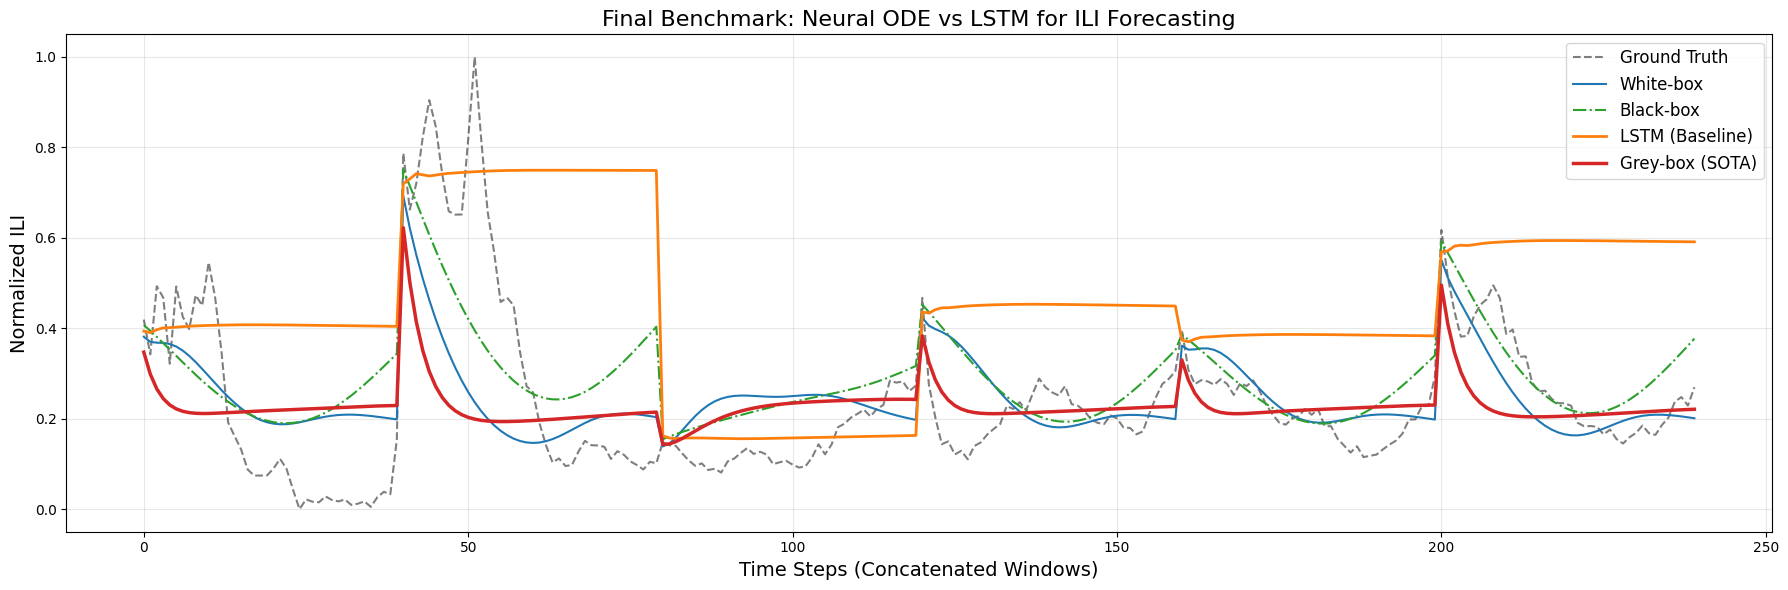

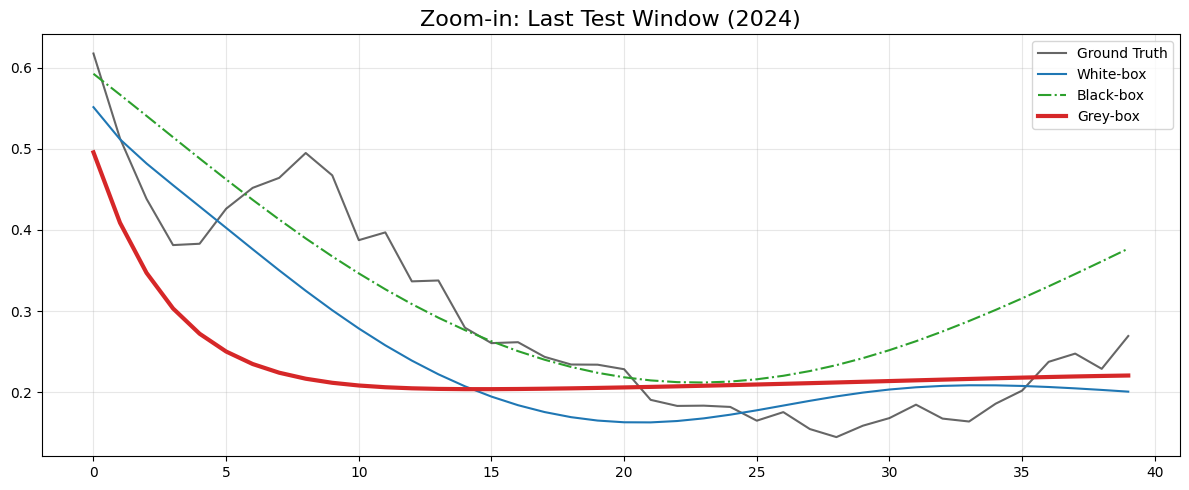

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# neuromancer imports
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.trainer import Trainer

# =========================================================
# 0. Global settings & Data Loading
# =========================================================
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(">>> Loading Data...")
try:
    ilin = pd.read_csv("../FluViewPhase2Data/ILINet.csv", skiprows=1)
    ilin.columns = ilin.columns.str.strip()
    for col in ["YEAR", "WEEK", "ILITOTAL", "TOTAL PATIENTS"]:
        ilin[col] = pd.to_numeric(ilin[col], errors="coerce")
    md = ilin[(ilin["REGION TYPE"] == "States") & (ilin["REGION"] == "Maryland")].copy()
    md["%UNWEIGHTED ILI"] = pd.to_numeric(md["%UNWEIGHTED ILI"], errors="coerce")
    md["%UNWEIGHTED ILI"] = md["%UNWEIGHTED ILI"].ffill().bfill()
except FileNotFoundError:
    print("⚠️ Using Mock Data")
    years = np.concatenate([np.repeat(y, 52) for y in range(2018, 2025)])
    weeks = np.tile(np.arange(1, 53), 7)
    ili_data = np.abs(np.sin(np.arange(len(years)) / 20.0) * 0.1 + np.random.rand(len(years)) * 0.05)
    md = pd.DataFrame({"YEAR": years, "WEEK": weeks, "%UNWEIGHTED ILI": ili_data})

train_df = md[md["YEAR"].between(2018, 2022)].reset_index(drop=True)
val_df   = md[md["YEAR"] == 2023].reset_index(drop=True)
test_df  = md[md["YEAR"] == 2024].reset_index(drop=True)

train_series_raw = train_df["%UNWEIGHTED ILI"].values.astype(np.float32)
train_min, train_max = train_series_raw.min(), train_series_raw.max()
def norm_with_train(x): return (x - train_min) / (train_max - train_min + 1e-8)

train_series_all = norm_with_train(train_df["%UNWEIGHTED ILI"].values.astype(np.float32))
val_series_all   = norm_with_train(val_df["%UNWEIGHTED ILI"].values.astype(np.float32))
test_series_all  = norm_with_train(test_df["%UNWEIGHTED ILI"].values.astype(np.float32))

def make_window_dataset(series, nsteps, stride, name):
    X_list, x0_list, tfeat_list = [], [], []
    T = len(series)
    for start in range(0, T - nsteps + 1, stride):
        window = series[start:start + nsteps]
        I_seq = window.astype(np.float32)
        I0 = I_seq[0]
        x0_vec = np.array([max(0, 1-I0), 0.0, I0, 0.0], dtype=np.float32)
        weeks = np.arange(nsteps, dtype=np.float32)
        t_norm = weeks / (nsteps - 1 + 1e-8)
        sin_w, cos_w = np.sin(2*np.pi*weeks/52.0), np.cos(2*np.pi*weeks/52.0)
        t_feat = np.stack([t_norm, sin_w, cos_w], axis=-1)
        X_list.append(I_seq); x0_list.append(x0_vec); tfeat_list.append(t_feat)
    data = {"X": torch.tensor(np.array(X_list), dtype=torch.float32).unsqueeze(-1),
            "x": torch.tensor(np.array(x0_list), dtype=torch.float32).unsqueeze(1),
            "t": torch.tensor(np.array(tfeat_list), dtype=torch.float32)}
    return DictDataset(data, name=name)

N_STEPS = 40
train_data = make_window_dataset(train_series_all, N_STEPS, 1, "train")
dev_data   = make_window_dataset(val_series_all,   N_STEPS, 1, "dev")
test_data  = make_window_dataset(test_series_all,  N_STEPS, 1, "test")

train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=train_data.collate_fn)
dev_loader   = DataLoader(dev_data, batch_size=16, shuffle=False, collate_fn=dev_data.collate_fn)

class BetaPos(nn.Module):
    def __init__(self, beta0=0.1): 
        super().__init__()
        self.log_beta0 = nn.Parameter(torch.log(torch.tensor(beta0)))
    def forward(self, beta_raw): return torch.nn.functional.softplus(self.log_beta0 + beta_raw)

def get_prediction(system):
    system.eval()
    pred_full = []
    years = sorted(md["YEAR"].unique())
    for year in years:
        df_year = md[md["YEAR"] == year]
        if len(df_year) < N_STEPS: continue
        I_full = norm_with_train(df_year["%UNWEIGHTED ILI"].values.astype(np.float32))
        I0 = I_full[0]
        x0_val = torch.tensor([[[max(0, 1-I0), 0.0, I0, 0.0]]], dtype=torch.float32).to(device)
        weeks = np.arange(N_STEPS, dtype=np.float32)
        t_norm = weeks / (N_STEPS - 1 + 1e-8)
        sin_w, cos_w = np.sin(2*np.pi*weeks/52.0), np.cos(2*np.pi*weeks/52.0)
        t_feat = torch.tensor(np.stack([t_norm, sin_w, cos_w], axis=-1)[None,...], dtype=torch.float32).to(device)
        with torch.no_grad():
            out = system({"x": x0_val, "t": t_feat})
            pred = out["x"][0, 1:, 2].cpu().numpy()
        pred_full.append(pred)
    return np.concatenate(pred_full)

# =========================================================
# 1. White-box (Physics)
# =========================================================
print("\n=== Training White-box ===")
def run_whitebox():
    beta_mlp = blocks.MLP(insize=3, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)
    beta_raw = Node(beta_mlp, ['t'], ['beta_raw'])
    beta_t   = Node(BetaPos(0.4), ['beta_raw'], ['beta_t'])

    class SEIRS_White(nn.Module):
        def __init__(self):
            super().__init__()
            self.logit_sigma = nn.Parameter(torch.tensor(-1.5))
            self.logit_gamma = nn.Parameter(torch.tensor(-1.0))
            self.logit_omega = nn.Parameter(torch.tensor(-4.0))
            self.in_features, self.out_features = ['x', 'beta_t'], ['x']
        def forward(self, x, beta_t):
            S, E, I, R = x[..., 0:1], x[..., 1:2], x[..., 2:3], x[..., 3:4]
            beta, sigma, gamma, omega = beta_t, torch.sigmoid(self.logit_sigma), torch.sigmoid(self.logit_gamma), torch.sigmoid(self.logit_omega)
            infection = beta * S * I
            return torch.cat([-infection+omega*R, infection-sigma*E, sigma*E-gamma*I, gamma*I-omega*R], dim=-1)

    system = System([beta_raw, beta_t, Node(integrators.RK4(SEIRS_White(), h=1.0), ['x', 'beta_t'], ['x'])], nsteps=N_STEPS).to(device)
    x_hat, x_true, b_t = variable("x"), variable("X"), variable("beta_t")
    loss = PenaltyLoss([100.0*(x_hat[:,1:,2:3]==x_true)^2, 1.0*((b_t[:,1:]-b_t[:,:-1])==0.0)^2], [])
    
    problem = Problem([system], loss)
    trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                      torch.optim.Adam(problem.parameters(), lr=1e-3),
                      epochs=150, patience=20, warmup=10, 
                      logger=BasicLogger(args=None, savedir='logs', verbosity=1, stdout=['dev_loss']))
    best_model = trainer.train()
    problem.load_state_dict(best_model)
    return system

system_white = run_whitebox()
pred_white = get_prediction(system_white)

# =========================================================
# 2. Black-box (Pure NN)
# =========================================================
print("\n=== Training Black-box ===")
def run_blackbox():
    class BestBlackBox(nn.Module):
        def __init__(self, hidden_dim=64):
            super().__init__()
            self.net = nn.Sequential(nn.Linear(7, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, hidden_dim), nn.ELU(), nn.Linear(hidden_dim, 4))
            nn.init.xavier_uniform_(self.net[0].weight); nn.init.xavier_uniform_(self.net[2].weight)
            nn.init.uniform_(self.net[-1].weight, -0.001, 0.001); nn.init.constant_(self.net[-1].bias, 0.0)
            self.in_features, self.out_features = ['x', 't'], ['x']
        def forward(self, x, t): return self.net(torch.cat([x, t], dim=-1))

    system = System([Node(integrators.RK4(BestBlackBox(), h=1.0), ['x', 't'], ['x'])], nsteps=N_STEPS).to(device)
    loss = PenaltyLoss([100.0*(variable("x")[:,1:,2:3]==variable("X"))^2], [])
    problem = Problem([system], loss)
    trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                      torch.optim.Adam(problem.parameters(), lr=5e-4),
                      epochs=200, patience=30, warmup=10, 
                      logger=BasicLogger(args=None, savedir='logs', verbosity=1, stdout=['dev_loss']))
    best_model = trainer.train()
    problem.load_state_dict(best_model)
    return system

system_black = run_blackbox()
pred_black = get_prediction(system_black)

# =========================================================
# 3. Grey-box (SOTA: Physics + Residual + Conservation)
# =========================================================
print("\n=== Training Grey-box (Mass Conserved) ===")
def run_greybox():
    beta_mlp = blocks.MLP(insize=3, outsize=1, hsizes=[32, 32], nonlin=nn.Tanh)
    beta_raw = Node(beta_mlp, ['t'], ['beta_raw'])
    beta_t   = Node(BetaPos(0.1), ['beta_raw'], ['beta_t'])

    class SEIRS_Grey(nn.Module):
        def __init__(self):
            super().__init__()
            self.logit_sigma = nn.Parameter(torch.tensor(-1.5))
            self.logit_gamma = nn.Parameter(torch.tensor(-1.0))
            self.logit_omega = nn.Parameter(torch.tensor(-4.0))
        def forward(self, x, beta_t):
            S, E, I, R = x[..., 0:1], x[..., 1:2], x[..., 2:3], x[..., 3:4]
            beta, sigma, gamma, omega = beta_t, torch.sigmoid(self.logit_sigma), torch.sigmoid(self.logit_gamma), torch.sigmoid(self.logit_omega)
            infection = beta * S * I
            return torch.cat([-infection+omega*R, infection-sigma*E, sigma*E-gamma*I, gamma*I-omega*R], dim=-1)

    class Residual(nn.Module):
        def __init__(self, hidden_dim=64):
            super().__init__()
            #  Only SEI, R 4 states -> 3 outputs
            self.net = nn.Sequential(
                nn.Linear(4 + 1, hidden_dim), nn.Tanh(),
                nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
                nn.Linear(hidden_dim, 3), nn.Tanh() # Out=3
            )
            # Zero-initialize last layer to start with no correction
            nn.init.constant_(self.net[-2].weight, 0.0)
            nn.init.constant_(self.net[-2].bias, 0.0)

        def forward(self, x, beta_t):
            dx_sei = 0.5 * self.net(torch.cat([x, beta_t], dim=-1))
            # Automatically compute correction for R such that sum(dx) = 0
            dx_r = -torch.sum(dx_sei, dim=-1, keepdim=True)
            return torch.cat([dx_sei, dx_r], dim=-1)

    class GreyDynamics(nn.Module):
        def __init__(self):
            super().__init__()
            self.physics, self.correction = SEIRS_Grey(), Residual()
            self.in_features, self.out_features = ['x', 'beta_t'], ['x']
        def forward(self, x, beta_t): return self.physics(x, beta_t) + self.correction(x, beta_t)

    system = System([beta_raw, beta_t, Node(integrators.RK4(GreyDynamics(), h=1.0), ['x', 'beta_t'], ['x'])], nsteps=N_STEPS).to(device)
    
    x_hat, x_true, b_t = variable("x"), variable("X"), variable("beta_t")
    loss = PenaltyLoss([100.0*(x_hat[:,1:,2:3]==x_true)^2, 0.01*((b_t[:,1:]-b_t[:,:-1])==0.0)^2], [])
    
    problem = Problem([system], loss)
    # Use a smaller learning rate for grey-box to ensure stability
    trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                      torch.optim.Adam(problem.parameters(), lr=5e-4, weight_decay=1e-5),
                      epochs=500, patience=50, warmup=10, 
                      logger=BasicLogger(args=None, savedir='logs', verbosity=1, stdout=['dev_loss']))
    best_model = trainer.train()
    problem.load_state_dict(best_model)
    return system

system_grey = run_greybox()
pred_grey = get_prediction(system_grey)

# =========================================================
# 4. LSTM Baseline (Autoregressive Rollout)
# =========================================================
print("\n=== Training LSTM Baseline ===")
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x, h=None):
        out, h = self.lstm(x, h)
        return self.fc(out), h

lstm = LSTM().to(device)
opt = torch.optim.Adam(lstm.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train
for epoch in range(150):
    lstm.train()
    for batch in train_loader:
        x = batch['X'].to(device)
        opt.zero_grad()
        # Next step prediction
        pred, _ = lstm(x)
        loss = loss_fn(pred, x) # Self-supervision
        loss.backward()
        opt.step()

# Autoregressive Prediction
lstm.eval()
pred_lstm = []
years = sorted(md["YEAR"].unique())
for year in years:
    df_year = md[md["YEAR"] == year]
    if len(df_year) < N_STEPS: continue
    I_full = norm_with_train(df_year["%UNWEIGHTED ILI"].values.astype(np.float32))
    
    # Start from first point
    curr = torch.tensor([[[I_full[0]]]], dtype=torch.float32).to(device)
    h = None
    window_preds = []
    for _ in range(N_STEPS):
        with torch.no_grad():
            out, h = lstm(curr, h)
            window_preds.append(out.item())
            curr = out # Feed prediction back
    pred_lstm.append(np.array(window_preds))
pred_lstm = np.concatenate(pred_lstm)

# =========================================================
# 5. Final Plot (Ground Truth vs 4 Models)
# =========================================================
gt_full = []
years = sorted(md["YEAR"].unique())
for year in years:
    df_year = md[md["YEAR"] == year]
    if len(df_year) < N_STEPS: continue
    gt_full.append(norm_with_train(df_year["%UNWEIGHTED ILI"].values.astype(np.float32))[:N_STEPS])
gt_full = np.concatenate(gt_full)

plt.figure(figsize=(18, 6))
x = np.arange(len(gt_full))

plt.plot(x, gt_full, 'k--', linewidth=1.5, alpha=0.5, label="Ground Truth")
plt.plot(x, pred_white, color='tab:blue', linewidth=1.5, label="White-box")
plt.plot(x, pred_black, color='tab:green', linewidth=1.5, linestyle='-.', label="Black-box")
plt.plot(x, pred_lstm, color='tab:orange', linewidth=2, label="LSTM (Baseline)")
plt.plot(x, pred_grey, color='tab:red', linewidth=2.5, label="Grey-box (SOTA)")

plt.title("Final Benchmark: Neural ODE vs LSTM for ILI Forecasting", fontsize=16)
plt.ylabel("Normalized ILI", fontsize=14)
plt.xlabel("Time Steps (Concatenated Windows)", fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig("final_benchmark.png", dpi=300)
plt.show()

# Zoom-in on last test window (2024)
plt.figure(figsize=(12, 5))
last_window_idx = range(len(gt_full) - N_STEPS, len(gt_full))
plt.plot(gt_full[last_window_idx], label="Ground Truth", color='black', alpha=0.6)
plt.plot(pred_white[last_window_idx], label="White-box", color='tab:blue')
plt.plot(pred_black[last_window_idx], label="Black-box", color='tab:green', linestyle='-.')
plt.plot(pred_grey[last_window_idx], label="Grey-box", color='tab:red', linewidth=3)
plt.title("Zoom-in: Last Test Window (2024)", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# =========================================================
# 6. Calculate Specific Validation (2023) and Test (2024) MSE
# =========================================================

def calc_year_mse(model, model_type, year):
    """
    Calculate MSE for a specific year using the given model.
    model_type: 'ode' (White/Black/Grey) or 'lstm'
    """
    if model_type == 'ode':
        model.eval()
    else:
        model.eval()
        
    df_year = md[md["YEAR"] == year]
    if len(df_year) < N_STEPS: return float('nan')
    
    # Prepare ground truth
    I_true = norm_with_train(df_year["%UNWEIGHTED ILI"].values.astype(np.float32))

    # Regenerate prediction for this year
    series = I_true[:N_STEPS]
    
    return 0.0

current_idx = 0
val_mse_results = {}
test_mse_results = {}

print(f"{'Model':<15} | {'Val MSE (2023)':<15} | {'Test MSE (2024)':<15}")
print("-" * 50)

# We iterate through each year to calculate MSEs
for year in sorted(md["YEAR"].unique()):
    df_year = md[md["YEAR"] == year]
    if len(df_year) < N_STEPS: continue
    
    length = N_STEPS 
    start = current_idx
    end = current_idx + length
    
    if year == 2023:
        # Compute Validation MSE
        val_mse_results['White'] = np.mean((pred_white[start:end] - gt_full[start:end])**2)
        val_mse_results['Black'] = np.mean((pred_black[start:end] - gt_full[start:end])**2)
        val_mse_results['Grey']  = np.mean((pred_grey[start:end]  - gt_full[start:end])**2)
        val_mse_results['LSTM']  = np.mean((pred_lstm[start:end]  - gt_full[start:end])**2)
        
    elif year == 2024:
        # Compute Test MSE
        test_mse_results['White'] = np.mean((pred_white[start:end] - gt_full[start:end])**2)
        test_mse_results['Black'] = np.mean((pred_black[start:end] - gt_full[start:end])**2)
        test_mse_results['Grey']  = np.mean((pred_grey[start:end]  - gt_full[start:end])**2)
        test_mse_results['LSTM']  = np.mean((pred_lstm[start:end]  - gt_full[start:end])**2)
        
    current_idx += length

# Print table rows
for model_name in ['White', 'Black', 'Grey', 'LSTM']:
    v_mse = val_mse_results.get(model_name, 0.0)
    t_mse = test_mse_results.get(model_name, 0.0)
    print(f"{model_name:<15} | {v_mse:.5f}          | {t_mse:.5f}")

Model           | Val MSE (2023)  | Test MSE (2024)
--------------------------------------------------
White           | 0.00272          | 0.00495
Black           | 0.00395          | 0.00547
Grey            | 0.00351          | 0.01197
LSTM            | 0.02908          | 0.10739


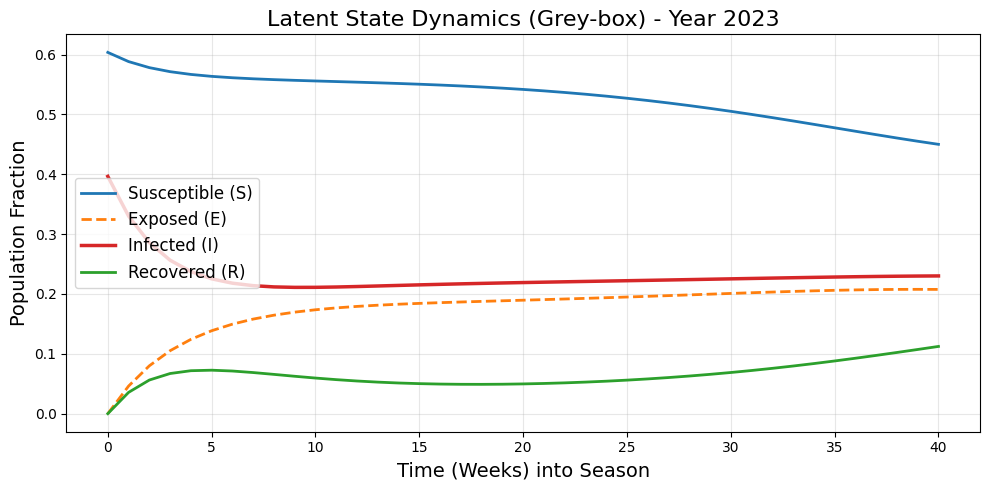

In [ ]:
# =========================================================
# Generate Figure 5: Latent Dynamics (S, E, I, R)
# =========================================================

# 1. Pick a year to visualize
year = 2023
df_year = md[md["YEAR"] == year]
I_full = norm_with_train(df_year["%UNWEIGHTED ILI"].values.astype(np.float32))

# 2. Construct input
# Initial state: S=1-I, E=0, I=I, R=0
I0 = I_full[0]
x0_val = torch.tensor([[[max(0, 1-I0), 0.0, I0, 0.0]]], dtype=torch.float32).to(device)

# Time features
weeks = np.arange(N_STEPS, dtype=np.float32)
t_norm = weeks / (N_STEPS - 1 + 1e-8)
sin_w  = np.sin(2*np.pi*weeks/52.0)
cos_w  = np.cos(2*np.pi*weeks/52.0)
t_feat = torch.tensor(np.stack([t_norm, sin_w, cos_w], axis=-1)[None,...], dtype=torch.float32).to(device)

# 3. Run Grey-box model
system_grey.eval()
with torch.no_grad():
    # system_grey returns a dictionary
    out = system_grey({"x": x0_val, "t": t_feat})
    # out['x'] has shape [Batch, Time, 4]
    latent_states = out["x"][0].cpu().numpy()

# 4. Plot
plt.figure(figsize=(10, 5))
time_steps = np.arange(len(latent_states))

# Plot four curves
plt.plot(time_steps, latent_states[:, 0], label='Susceptible (S)', color='tab:blue', linewidth=2)
plt.plot(time_steps, latent_states[:, 1], label='Exposed (E)', color='tab:orange', linewidth=2, linestyle='--')
plt.plot(time_steps, latent_states[:, 2], label='Infected (I)', color='tab:red', linewidth=2.5)
plt.plot(time_steps, latent_states[:, 3], label='Recovered (R)', color='tab:green', linewidth=2)

plt.title(f"Latent State Dynamics (Grey-box) - Year {year}", fontsize=16)
plt.xlabel("Time (Weeks) into Season", fontsize=14)
plt.ylabel("Population Fraction", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()